In [ ]:
!git clone https://github.com/anminhhung/small_dog_cat_dataset

Cloning into 'small_dog_cat_dataset'...
remote: Enumerating objects: 2608, done.
remote: Total 2608 (delta 0), reused 0 (delta 0), pack-reused 2608
Receiving objects: 100% (2608/2608), 55.84 MiB | 13.13 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision
import torch.nn as nn
from sklearn.model_selection import train_test_split
import cv2
import os
import albumentations

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Dataloader


In [ ]:
class DogCatDataset(Dataset):
  def __init__(self, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = {"dogs": 0, "cats": 1}
    for sub_dir in os.listdir(root_dir):
      path_sub_dir = os.path.join(root_dir, sub_dir)
      for image_name in os.listdir(path_sub_dir):
        image_path = os.path.join(path_sub_dir, image_name)
        label = sub_dir
        self.list_images_path.append(image_path)
        self.list_labels.append(label)

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (384, 384))
    label = np.array(self.one_hot_label[self.list_labels[idx]]) # .astype('float')

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)

    image = image.transpose(2, 0, 1)
    sample = (image, label)

    return sample # image, label

In [ ]:
def get_transforms(image_size=(224, 224)):

    transforms_train = albumentations.Compose([
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
        # albumentations.Resize(image_size, image_size),
        # albumentations.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        albumentations.Normalize(),
        albumentations.RandomBrightnessContrast(p=0.2),
    ])

    transforms_val = albumentations.Compose([
        # albumentations.Resize(image_size, image_size),
        albumentations.Normalize()
    ])

    return transforms_train, transforms_val

In [ ]:
transforms_train, transforms_val = get_transforms(image_size=(224, 224))

In [ ]:
transformed_train_data = DogCatDataset('small_dog_cat_dataset/train', transform=transforms_train)
transformed_test_data = DogCatDataset('small_dog_cat_dataset/test', transform=transforms_val)

In [ ]:
train_data_loader = DataLoader(transformed_train_data, batch_size=16, shuffle=True)
test_data_loader = DataLoader(transformed_test_data, batch_size=16, shuffle=True)

# VIT

In [ ]:
class PatchEmbed(nn.Module):
  def __init__(self, image_size, patch_size, in_channels=3, embed_dims=768):
    super().__init__()
    self.image_size = image_size
    self.patch_size = patch_size
    self.n_patches = (image_size // patch_size) ** 2


    # custom patch
    '''
    self.patch_size = (image_size//4, image_size//2)
    self.n_patches = (image_size // self.patch_size[0])*((image_size // self.patch_size[1]))
    '''

    # convolutional layer that does both the splitting into patches and their embedding
    self.cv2D_layer = nn.Conv2d(in_channels, embed_dims, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    '''
      input: X tensor - Shape: (n_samples, in_chans, image_size, image_size).
      output: tensor - Shape: (n_samples, n_patches, embed_dim)
    '''
    x = self.cv2D_layer(x) # Shape: (n_samples, embed_dims, patch_size // 2, patch_size // 2)
    x = x.flatten(2) # Shape: (n_samples, embed_dims, n_patches)
    x = x.transpose(1, 2) # Shape: (n_samples, n_patches, embed_dims)

    return x

In [ ]:
class Attention(nn.Module):
  def __init__(self, dim, n_heads=12, qkv_bias=True, drop_attn_ratio=0., drop_ratio=0.):
    super().__init__()
    self.n_heads = n_heads
    self.dim = dim
    self.head_dim = dim // n_heads
    self.scale = self.head_dim ** -0.5

    self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
    self.attn_drop = nn.Dropout(drop_attn_ratio)
    self.fc = nn.Linear(dim, dim)
    self.fc_drop = nn.Dropout(drop_ratio)

  def forward(self, x):
    '''
      input: Shape: (n_samples, n_patches + 1, dim)
      output: (n_samples, n_patches + 1, dim)
    '''
    n_samples, n_token, dim = x.shape
    if dim != self.dim:
      raise ValueError

    qkv = self.qkv(x) # shape: (n_samples, n_patches+1, dim*3)
    qkv = qkv.reshape(n_samples, n_token, 3, self.n_heads, self.head_dim) # shape: (n_samples, n_patches + 1, 3, n_heads, head_dim)
    qkv = qkv.permute(2, 0, 3, 1, 4) # shape (3, n_samples, n_heads, n_patches+1, head_dim)
    q, k, v = qkv[0], qkv[1], qkv[2]
    k_t = k.transpose(-2, -1)  # shape: (n_samples, n_heads, head_dim, n_patches + 1)
    dot_product = (q @ k_t) * self.scale # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = dot_product.softmax(dim=-1)  # shape: (n_samples, n_heads, n_patches + 1, n_patches + 1)
    attn = self.attn_drop(attn)
    weighted_avg = attn @ v  # shape: (n_samples, n_heads, n_patches +1, head_dim)
    weighted_avg = weighted_avg.transpose(1, 2)  # shape: (n_samples, n_patches + 1, n_heads, head_dim)
    weighted_avg = weighted_avg.flatten(2)  # shape: (n_samples, n_patches + 1, dim)
    x = self.fc(weighted_avg)
    x = self.fc_drop(x)

    return x

In [ ]:
class MLP(nn.Module):
  def __init__(self, in_features, hidden_features, out_features, drop_ratio=0.):
    super().__init__()
    self.fc1 = nn.Linear(in_features, hidden_features)
    self.activation_func = nn.GELU()
    self.fc2 = nn.Linear(hidden_features, out_features)
    self.dropout = nn.Dropout(drop_ratio)

  def forward(self, x):
    x = self.fc1(x)
    x = self.activation_func(x)
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.dropout(x)

    return x

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, dim, n_heads, mlp_ratio=4.0, qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.norm1 = nn.LayerNorm(dim, eps=1e-6)
    self.attn = Attention(dim, n_heads=n_heads, qkv_bias=qkv_bias, drop_attn_ratio=dropout_attn_ratio, drop_ratio=dropout_ratio)
    self.norm2 = nn.LayerNorm(dim, eps=1e-6)
    hidden_features = int(dim * mlp_ratio)
    self.mlp = MLP(in_features=dim, hidden_features=hidden_features, out_features=dim)

  def forward(self, x):
    x = x + self.attn(self.norm1(x))
    x = x + self.mlp(self.norm2(x))

    return x

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self, n_classes=2, image_size=384, patch_size=16, in_channels=3, embed_dims=768, depth=12, \
               n_heads=12, mlp_ratio=4., qkv_bias=True, dropout_attn_ratio=0., dropout_ratio=0.):
    super().__init__()
    self.patch_embed = PatchEmbed(image_size=image_size, patch_size=patch_size, in_channels=in_channels, embed_dims=embed_dims)
    self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dims))
    self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dims))
    self.pos_drop = nn.Dropout(dropout_ratio)
    self.blocks = nn.ModuleList(
      [
          TransformerBlock(
            dim = embed_dims,
            n_heads = n_heads,
            mlp_ratio = mlp_ratio,
            qkv_bias = qkv_bias,
            dropout_attn_ratio = dropout_attn_ratio,
            dropout_ratio = dropout_ratio
          )
          for _ in range(depth)
      ]
    )
    self.norm = nn.LayerNorm(embed_dims, eps=1e-6)
    self.head = nn.Linear(embed_dims, n_classes)

  def forward(self, x):
    n_samples = x.shape[0]
    x = self.patch_embed(x)
    cls_token = self.cls_token.expand(n_samples, -1, -1)
    x = torch.cat((cls_token, x), dim=1)  # (n_samples, 1 + n_patches, embed_dims)
    x = x + self.pos_embed
    x = self.pos_drop(x)
    for block in self.blocks:
      x = block(x)
    x = self.norm(x)
    cls_token_final = x[:, 0]
    x = self.head(cls_token_final)

    return x

# Train

In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            torch.save(model.state_dict(), "save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))
            print("[INFO] save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

In [ ]:
model = VisionTransformer(2).to(device)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=3e-4)
loss_function = nn.CrossEntropyLoss()

Epochs: 0, Train_loss: 0.7082995147705078, Valid_loss: 0.6906875481731013, Train_accuracy: 54.800000000000004, Valid_accuracy: 53.833333333333336
[INFO] save_model/epoch_0_acc53.833333333333336.pth
Epochs: 1, Train_loss: 0.6889857573509216, Valid_loss: 0.6953913396910617, Train_accuracy: 50.349999999999994, Valid_accuracy: 52.5
[INFO] save_model/epoch_1_acc52.5.pth
Epochs: 2, Train_loss: 0.6816766009330749, Valid_loss: 0.6978369951248169, Train_accuracy: 51.2, Valid_accuracy: 51.5
[INFO] save_model/epoch_2_acc51.5.pth
Epochs: 3, Train_loss: 0.6782170133590698, Valid_loss: 0.661416083574295, Train_accuracy: 59.150000000000006, Valid_accuracy: 59.0
[INFO] save_model/epoch_3_acc59.0.pth
Epochs: 4, Train_loss: 0.6728967056274414, Valid_loss: 0.6574045027557173, Train_accuracy: 58.550000000000004, Valid_accuracy: 61.33333333333333
[INFO] save_model/epoch_4_acc61.33333333333333.pth


<ipython-input-25-49987f100832>:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


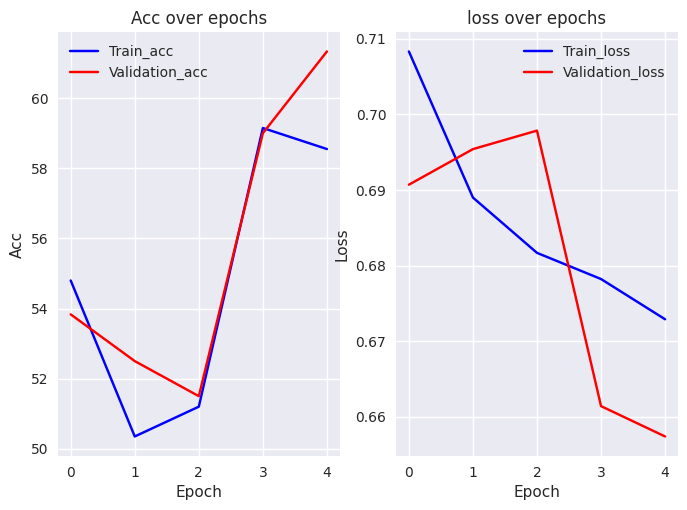

In [ ]:
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_data_loader, test_data_loader, 5, device)